In [24]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import History
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Activation 
from keras.optimizers import Adam
from keras.layers import Bidirectional
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [35]:
def load_data():
    data = pd.read_csv(r'data_collection\AAPL.csv', date_parser=True)
    data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
    data['MA'] = ta.trend.SMAIndicator(data['Close'], window=20).sma_indicator()
    data['EMA'] = ta.trend.EMAIndicator(data['Close'], window=20).ema_indicator()
    bb = ta.volatility.BollingerBands(data['Close'], window=20, window_dev=2)
    data['BB_upper'] = bb.bollinger_hband()
    data['BB_middle'] = bb.bollinger_mavg()
    data['BB_lower'] = bb.bollinger_lband()
    data = data[['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Adj Close', 'RSI', 'MA', 'EMA', 'BB_upper', 'BB_middle', 'BB_lower']]
    data = data.set_index('Date')
    data = data.dropna()
    return data

In [26]:
# remove NaN values
def preprocess_data(data):
    train_size = int(len(data) * 0.7)
    train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    return train_data, test_data, scaler

# prepare the data for LSTM
def prepare_data(data, window_size, num_steps):
    X, Y = [], []
    for i in range(len(data) - window_size - num_steps + 1):
        X.append(data[i:(i + window_size), :])
        Y.append(data[(i + window_size):(i + window_size + num_steps), 1])  # predict 'num_steps' Close values
    X = np.array(X)
    Y = np.array(Y)
    return X, Y


In [27]:

def build_model(trainX, num_steps):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01))))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False, kernel_regularizer=l2(0.01))))
    model.add(Dropout(0.3))
    model.add(Dense(num_steps))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'mae'])
    return model

In [28]:
def train_model(model, trainX, trainY, testX, testY):
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    history = model.fit(trainX, trainY, epochs=2000, batch_size=32, shuffle=True, 
                        validation_data=(testX, testY), verbose=2, callbacks=[early_stopping])
    return history

In [29]:
def evaluate_model(model, testX, testY, train_data, scaler, num_steps):
    predictions = model.predict(testX)
    dummy_cols_pred = np.zeros((predictions.shape[0], train_data.shape[1] - num_steps))
    predictions = np.hstack((predictions, dummy_cols_pred))
    unscaled_predictions = scaler.inverse_transform(predictions)[:, :num_steps]
    dummy_cols_actual = np.zeros((testY.shape[0], train_data.shape[1] - num_steps))
    actual = np.hstack((testY, dummy_cols_actual))
    unscaled_actual = scaler.inverse_transform(actual)[:, :num_steps]
    mse = mean_squared_error(unscaled_actual, unscaled_predictions)
    mae = mean_absolute_error(unscaled_actual, unscaled_predictions)
    mape = np.mean(np.abs((unscaled_actual - unscaled_predictions) / unscaled_actual)) * 100
    rmse = np.sqrt(mse)
    r2_score = 1 - (np.sum((unscaled_actual - unscaled_predictions)**2) / np.sum((unscaled_actual - np.mean(unscaled_actual))**2))
    if num_steps > train_data.shape[1]:
        raise ValueError(f"Can't predict {num_steps} steps ahead. The maximum number of steps is {train_data.shape[1]}.")
    return mse, mae, mape, rmse, r2_score, unscaled_predictions, unscaled_actual

In [36]:
def save_model(model):
    model.save(r'trained_models\trained_model.h17')

In [31]:
# Load the data
data = load_data()
# Preprocess the data
train_data, test_data, scaler = preprocess_data(data)

In [32]:
# Prepare the data for LSTM
window_size = 10  # Use 10 previous time steps as input features
num_steps = 1  # Predict 1 future time steps
trainX, trainY = prepare_data(train_data, window_size, num_steps)
testX, testY = prepare_data(test_data, window_size, num_steps)
# Build the LSTM model
model = build_model(trainX, num_steps)

Epoch 1/2000
16/16 - 6s - loss: 6.9009 - mse: 0.0710 - mae: 0.1953 - val_loss: 5.4764 - val_mse: 0.0407 - val_mae: 0.1739 - 6s/epoch - 371ms/step
Epoch 2/2000
16/16 - 0s - loss: 4.4975 - mse: 0.0170 - mae: 0.1005 - val_loss: 3.5124 - val_mse: 0.0111 - val_mae: 0.0928 - 241ms/epoch - 15ms/step
Epoch 3/2000
16/16 - 0s - loss: 2.8706 - mse: 0.0123 - mae: 0.0851 - val_loss: 2.2172 - val_mse: 0.0078 - val_mae: 0.0779 - 244ms/epoch - 15ms/step
Epoch 4/2000
16/16 - 0s - loss: 1.8069 - mse: 0.0138 - mae: 0.0890 - val_loss: 1.3817 - val_mse: 0.0046 - val_mae: 0.0560 - 243ms/epoch - 15ms/step
Epoch 5/2000
16/16 - 0s - loss: 1.1274 - mse: 0.0135 - mae: 0.0891 - val_loss: 0.8571 - val_mse: 0.0047 - val_mae: 0.0574 - 242ms/epoch - 15ms/step
Epoch 6/2000
16/16 - 0s - loss: 0.7007 - mse: 0.0118 - mae: 0.0806 - val_loss: 0.5323 - val_mse: 0.0055 - val_mae: 0.0645 - 237ms/epoch - 15ms/step
Epoch 7/2000
16/16 - 0s - loss: 0.4366 - mse: 0.0104 - mae: 0.0774 - val_loss: 0.3304 - val_mse: 0.0035 - val_mae:

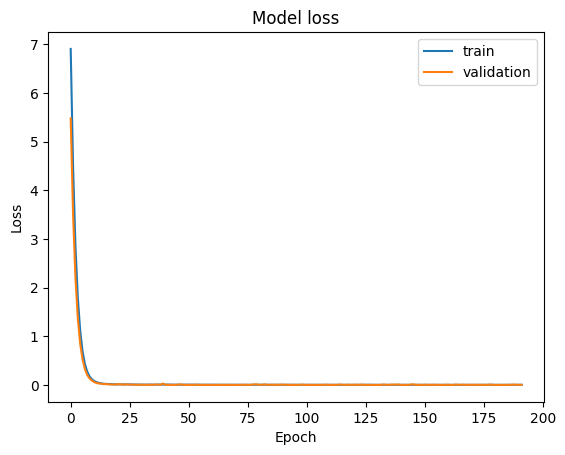

In [33]:
# Train the model
history = train_model(model, trainX, trainY, testX, testY)
# Graph loss and validation loss in one graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


7/7 [==============================] - 1s 4ms/step
MSE: 13.604281346222352 MAE: 2.9884682640149856 MAPE: 1.9168919523281898 RMSE: 3.68839820873809 R2 Score: 0.9595948938191774


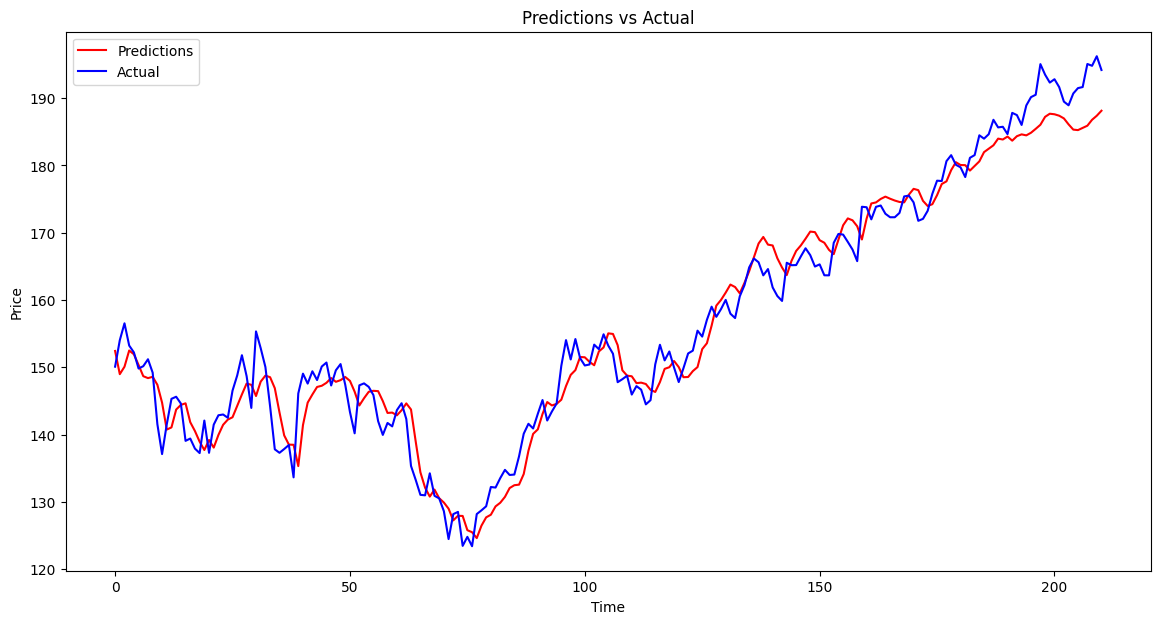

INFO:tensorflow:Assets written to: C:\Users\zobev\LSTM-WEB\trained_models\trained_model.h17\assets


INFO:tensorflow:Assets written to: C:\Users\zobev\LSTM-WEB\trained_models\trained_model.h17\assets


In [34]:
# Evaluate the model
from turtle import color


mse, mae, mape, rmse, r2_score, unscaled_predictions, unscaled_actual = evaluate_model(model, testX, testY, train_data, scaler, num_steps)
print('MSE:', mse, 'MAE:', mae, 'MAPE:', mape,'RMSE:', rmse, 'R2 Score:', r2_score)

# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(unscaled_predictions, label='Predictions', color='red')
plt.plot(unscaled_actual, label='Actual', color='blue')
plt.title('Predictions vs Actual')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc='upper left')
plt.show()

# Save the model
save_model(model)